In [23]:
# ────────────────────────────── 0. Imports ───────────────────────────────
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Input, Embedding, Dense, Dropout, LayerNormalization, Add,
    Bidirectional, LSTM,
    Conv1D, GlobalMaxPooling1D, concatenate,
    MultiHeadAttention, GlobalAveragePooling1D,
)
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras import backend as K

In [3]:
# ───────────────────────────── 1. Hyper-params ────────────────────────────
MAX_WORDS   = 20_000       # size of the word vocabulary
MAX_LEN     = 32           # sequence length after padding / truncation
BATCH_SIZE  = 32
EPOCHS      = 20
PATIENCE_ES = 3            # EarlyStopping patience
PATIENCE_LR = 2            # LR-scheduler patience
SEED        = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
# ───────────────────────────── 2. Load & Clean ───────────────────────────
DATA_DIR = Path('../data/goemotions')

df = pd.concat([pd.read_csv(p) for p in DATA_DIR.glob('goemotions_*.csv')],
               ignore_index=True)

def basic_clean(text: str) -> str:
    """Lower-case, drop HTML, punctuation, duplicate spaces."""
    text = re.sub(r'<.*?>', '', text.lower())          # remove HTML
    text = re.sub(r'[^a-z0-9\s]', '', text)            # keep alphanum/space
    return re.sub(r'\s+', ' ', text).strip()

df['clean_text'] = df['text'].astype(str).apply(basic_clean)

# -------------------------------------------------------------------------
# Make sure emotion columns are numeric (int8 saves RAM)
# -------------------------------------------------------------------------
META = {'text','id','author','subreddit','link_id','parent_id',
        'created_utc','rater_id','example_very_unclear'}
label_cols = [c for c in df.columns if c not in META and c != 'clean_text']
df[label_cols] = df[label_cols].astype('int8')

In [6]:
# ───────────────────────────── 3. Train / Val / Test split ───────────────
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [7]:
# ───────────────────────────── 4. Tokenisation ───────────────────────────
# 4-a Build vocabulary on the training set
counter = Counter(); [counter.update(t.split()) for t in train_df['clean_text']]
vocab = [w for w,_ in counter.most_common(MAX_WORDS-1)]
word2idx = {w:i+2 for i,w in enumerate(vocab)}  # 0=PAD,1=OOV
VOCAB_SIZE = MAX_WORDS + 2

def text_to_ids(txt): return [word2idx.get(tok,1) for tok in txt.split()]
def pad32(seq): return (seq[:MAX_LEN] + [0]*MAX_LEN)[:MAX_LEN]
def to_tensor(series): return np.array([pad32(text_to_ids(t)) for t in series],
                                       dtype=np.int16)

train_x = to_tensor(train_df['clean_text'])
val_x   = to_tensor(val_df['clean_text'])
test_x  = to_tensor(test_df['clean_text'])

train_y = train_df[label_cols].values
val_y   = val_df[label_cols].values
test_y  = test_df[label_cols].values
N_LABELS = len(label_cols)

In [8]:
# ─────────── 4-bis-prep. Derive positive / negative flags if missing ─────
if 'positive' not in df.columns:
    pos_emotions = ['admiration','amusement','approval','caring','desire',
                    'excitement','gratitude','joy','love','optimism',
                    'pride','relief']
    neg_emotions = ['anger','annoyance','confusion','disappointment',
                    'disapproval','disgust','embarrassment','fear','grief',
                    'nervousness','remorse','sadness']
    missing = set(pos_emotions + neg_emotions) - set(label_cols)
    if missing:
        raise ValueError(f'Missing emotion columns: {missing}')
    df['positive'] = (df[pos_emotions].sum(axis=1) > 0).astype('int8')
    df['negative'] = (df[neg_emotions].sum(axis=1) > 0).astype('int8')
    print('Derived positive / negative flags.')
else:
    print('positive / negative already present.')

Derived positive / negative flags.


In [9]:
# ░░░░░░░░░░░ 4-bis. Binary Sentiment Dataset (GoEmotions) ░░░░░░░░░░░
print('\n=== Building binary sentiment subset ===')

mask_bin = (df['positive']==1) ^ (df['negative']==1)
sent_df  = df.loc[mask_bin, ['clean_text','positive']].copy()
sent_df.rename(columns={'positive':'label'}, inplace=True)

X_train_txt, X_test_txt, y_train_bin, y_test_bin = train_test_split(
    sent_df['clean_text'], sent_df['label'],
    test_size=0.2, random_state=SEED, stratify=sent_df['label']
)
X_train_bin = to_tensor(X_train_txt)
X_test_bin  = to_tensor(X_test_txt)

print(f'Train {len(X_train_bin):,} samples  pos-ratio {y_train_bin.mean():.2f}')

def build_sentiment_cnn():
    inp = Input((MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, 128)(inp)
    x   = Conv1D(128, 5, activation='relu')(x)
    x   = GlobalMaxPooling1D()(x)
    x   = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    m   = keras.Model(inp, out)
    m.compile(Adam(1e-3), 'binary_crossentropy', metrics=['accuracy'])
    return m

sent_cnn = build_sentiment_cnn()
sent_cnn.fit(X_train_bin, y_train_bin,
             validation_split=0.1,
             epochs=6, batch_size=128,
             callbacks=[keras.callbacks.EarlyStopping(patience=2,
                                                      restore_best_weights=True)],
             verbose=2)
print(f'Binary sentiment accuracy: {sent_cnn.evaluate(X_test_bin, y_test_bin, verbose=0)[1]:.3f}')
sent_cnn.save('sentiment_goemotions_cnn.keras')
print('Saved -> sentiment_goemotions_cnn.keras\n')


=== Building binary sentiment subset ===
Train 104,800 samples  pos-ratio 0.58
Epoch 1/6
737/737 - 49s - 67ms/step - accuracy: 0.7819 - loss: 0.4504 - val_accuracy: 0.8282 - val_loss: 0.3885
Epoch 2/6
737/737 - 48s - 66ms/step - accuracy: 0.8477 - loss: 0.3513 - val_accuracy: 0.8342 - val_loss: 0.3895
Epoch 3/6
737/737 - 46s - 62ms/step - accuracy: 0.8701 - loss: 0.3056 - val_accuracy: 0.8339 - val_loss: 0.4118
Binary sentiment accuracy: 0.823
Saved -> sentiment_goemotions_cnn.keras



In [10]:
# ───────────────────────────── 5. Class Weights ──────────────────────────
pos = train_y.sum(axis=0)
neg = len(train_y) - pos
# inverse frequency; cap very rare labels to 25× weight
class_weight = {i: float(np.clip(neg[i] / pos[i], 1.0, 25.0))
                for i in range(N_LABELS)}

In [11]:
# ───────────────────────────── 6. Macro-F1 Callback ──────────────────────
class MacroF1(Callback):
    """Compute macro-F1 on validation set after each epoch."""
    def __init__(self, val_data):
        super().__init__()
        self.val_x, self.val_y = val_data
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.val_x, verbose=0) > 0.5).astype(int)
        f1 = f1_score(self.val_y, preds, average='macro')
        self.history.append(f1)
        print(f' — val_macro_f1: {f1:.4f}')

In [12]:
# ───────────────────────────── 7. Encoder Blocks ─────────────────────────
def build_lstm(emb_dim=100, units=128):
    inp = Input(shape=(MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, emb_dim)(inp)
    x   = Bidirectional(LSTM(units))(x)
    x   = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model

def build_cnn(emb_dim=100, filters=64, kernel_sizes=(3,4,5)):
    inp = Input(shape=(MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, emb_dim)(inp)
    pooled = [GlobalMaxPooling1D()(Conv1D(filters, k, activation='relu')(x))
              for k in kernel_sizes]
    x   = concatenate(pooled)
    x   = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model

# ---- tiny Transformer encoder ------------------------------------------
def tfm_block(x, heads=4, proj=64, mlp_dim=128):
    """One transformer encoder block with residual connections."""
    attn_out = MultiHeadAttention(num_heads=heads, key_dim=proj)(x, x)
    x = LayerNormalization()(Add()([x, attn_out]))

    mlp_out = Dense(mlp_dim, activation='relu')(x)
    mlp_out = Dense(x.shape[-1])(mlp_out)
    return LayerNormalization()(Add()([x, mlp_out]))

def build_transformer(emb_dim=128, blocks=2, heads=4):
    inp = Input(shape=(MAX_LEN,))
    tok_emb = Embedding(VOCAB_SIZE, emb_dim)(inp)
    # learnable positional embedding
    pos_emb = Embedding(MAX_LEN, emb_dim)(tf.range(MAX_LEN)[None, :])
    x = tok_emb + pos_emb

    for _ in range(blocks):
        x = tfm_block(x, heads, emb_dim // heads, emb_dim * 2)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model
# ------------------------------------------------------------------------

# Common callbacks
CALLBACKS = [
    keras.callbacks.EarlyStopping(patience=PATIENCE_ES, restore_best_weights=True,
                                  min_delta=1e-4),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=PATIENCE_LR,
                                      min_lr=1e-6, verbose=1)
]

def train_model(build_fn, name):
    """Utility: build, fit, return trained model + F1 curve."""
    K.clear_session()                                   # free GPU/CPU memory
    model = build_fn()
    f1_cb = MacroF1((val_x, val_y))
    model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              class_weight=class_weight,
              callbacks=[f1_cb, *CALLBACKS],
              verbose=2)
    return model, f1_cb.history

In [13]:
# ───────────────────────────── 7.1 Hyperparameter Tuning ────────────────────────
def hyperparameter_search_cnn_efficient():
    """More efficient grid search for CNN hyperparameters."""
    print("\n=== CNN Hyperparameter Tuning (Efficient) ===")
    best_f1 = 0
    best_params = {}
    results = []
    
    # Check if GPU is available
    gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
    print(f"GPU available: {gpu_available}")
    
    # Smaller parameter grid
    param_grid = {
        'emb_dim': [100],          # Reduced from [50, 100, 200]
        'filters': [64, 128],       # Reduced from [32, 64, 128]
        'dropout': [0.5]            # Reduced from [0.3, 0.5, 0.7]
    }
    
    # Create a smaller subset for faster tuning
    sample_size = min(5000, len(train_x))
    indices = np.random.choice(len(train_x), sample_size, replace=False)
    train_x_sample = train_x[indices]
    train_y_sample = train_y[indices]
    
    print(f"Using {sample_size} samples for tuning (from {len(train_x)} total)")
    
    # Display total combinations
    total_combinations = len(param_grid['emb_dim']) * len(param_grid['filters']) * len(param_grid['dropout'])
    print(f"Testing {total_combinations} parameter combinations")
    
    for emb_dim in param_grid['emb_dim']:
        for filters in param_grid['filters']:
            for dropout in param_grid['dropout']:
                params = {
                    'emb_dim': emb_dim,
                    'filters': filters,
                    'dropout': dropout
                }
                print(f"\nTesting: emb_dim={emb_dim}, filters={filters}, dropout={dropout}")
                
                # Define model with these hyperparameters
                def build_model():
                    inp = Input(shape=(MAX_LEN,))
                    x = Embedding(VOCAB_SIZE, emb_dim)(inp)
                    pooled = [GlobalMaxPooling1D()(Conv1D(filters, k, activation='relu')(x))
                             for k in [3, 4, 5]]
                    x = concatenate(pooled)
                    x = Dropout(dropout)(x)
                    out = Dense(N_LABELS, activation='sigmoid')(x)
                    model = keras.Model(inp, out)
                    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
                    return model
                
                # Train with fewer epochs for hyperparameter search
                K.clear_session()
                model = build_model()
                f1_cb = MacroF1((val_x, val_y))
                
                history = model.fit(
                    train_x_sample, train_y_sample,  # Using sampled data
                    validation_data=(val_x, val_y),
                    epochs=3,  # Reduced epochs for faster tuning
                    batch_size=BATCH_SIZE,
                    callbacks=[f1_cb],  # Reduced callbacks
                    class_weight=class_weight,
                    verbose=1
                )
                
                # Get best F1 score
                val_f1 = max(f1_cb.history)
                
                # Track results
                results.append({**params, 'val_f1': val_f1})
                
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_params = params
                
                # Free memory
                K.clear_session()
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    print(f"\nBest parameters: {best_params}, F1: {best_f1:.4f}")
    print("\nAll configurations:")
    print(results_df.sort_values('val_f1', ascending=False).to_string(index=False))
    
    return best_params

In [14]:
# ───────────────────────────── 7.2 Cross-Validation ────────────────────────
def cross_validate_model_efficient(build_fn, name, k=3):
    """Perform k-fold cross-validation on the model with efficiency optimizations."""
    print(f"\n=== {name} {k}-Fold Cross-Validation (Efficient) ===")
    
    # Create k folds with fewer splits
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    
    # Combine train and validation data for CV
    combined_x = np.concatenate([train_x, val_x])
    combined_y = np.concatenate([train_y, val_y])
    
    # Take a sample to speed up cross-validation
    sample_size = min(10000, len(combined_x))
    indices = np.random.choice(len(combined_x), sample_size, replace=False)
    combined_x_sample = combined_x[indices]
    combined_y_sample = combined_y[indices]
    
    print(f"Using {sample_size} samples for CV (from {len(combined_x)} total)")
    
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(combined_x_sample)):
        print(f"\nTraining fold {fold+1}/{k}")
        
        # Get fold data
        fold_train_x = combined_x_sample[train_idx]
        fold_train_y = combined_y_sample[train_idx]
        fold_val_x = combined_x_sample[val_idx]
        fold_val_y = combined_y_sample[val_idx]
        
        # Build and train model
        K.clear_session()
        model = build_fn()
        f1_cb = MacroF1((fold_val_x, fold_val_y))
        
        model.fit(
            fold_train_x, fold_train_y,
            validation_data=(fold_val_x, fold_val_y),
            epochs=5,  # Further reduced epochs
            batch_size=BATCH_SIZE * 2,  # Larger batch size for speed
            callbacks=[f1_cb],  # Minimal callbacks
            class_weight=class_weight,
            verbose=1
        )
        
        # Get best F1 score
        best_f1 = max(f1_cb.history)
        fold_scores.append(best_f1)
        
        print(f"Fold {fold+1} best F1: {best_f1:.4f}")
    
    # Calculate aggregate statistics
    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    
    # Print summary
    print(f"\n{name} Cross-validation results:")
    print(f"F1 scores: {[f'{x:.4f}' for x in fold_scores]}")
    print(f"Mean F1: {mean_f1:.4f}, Std: {std_f1:.4f}")
    
    return {'f1_scores': fold_scores, 'mean_f1': mean_f1, 'std_f1': std_f1}

In [15]:
# ───────────────────────────── 8. Train all three encoders ───────────────
lstm_model, hist_lstm = train_model(build_lstm, 'LSTM')
cnn_model,  hist_cnn  = train_model(build_cnn,  'CNN')
tfm_model,  hist_tfm  = train_model(build_transformer, 'TFM')

Epoch 1/20
 — val_macro_f1: 0.1276
5281/5281 - 332s - 63ms/step - binary_accuracy: 0.9590 - loss: 2.3058 - val_binary_accuracy: 0.9600 - val_loss: 0.1357 - learning_rate: 0.0010
Epoch 2/20
 — val_macro_f1: 0.1786
5281/5281 - 367s - 70ms/step - binary_accuracy: 0.9598 - loss: 1.9936 - val_binary_accuracy: 0.9601 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 3/20
 — val_macro_f1: 0.2021
5281/5281 - 454s - 86ms/step - binary_accuracy: 0.9601 - loss: 1.8989 - val_binary_accuracy: 0.9602 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 4/20
 — val_macro_f1: 0.2195
5281/5281 - 297s - 56ms/step - binary_accuracy: 0.9603 - loss: 1.8338 - val_binary_accuracy: 0.9600 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 5/20
 — val_macro_f1: 0.2279

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5281/5281 - 383s - 73ms/step - binary_accuracy: 0.9605 - loss: 1.7816 - val_binary_accuracy: 0.9599 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 6/20
 — val_macro_f1: 0.245

In [20]:
# ───────────────────────────── 9. Per-class threshold tuning ─────────────
# Use Transformer as best model; you can reuse this function for others.
val_prob = tfm_model.predict(val_x, batch_size=256, verbose=0)
opt_thr  = np.zeros(N_LABELS)

for i in range(N_LABELS):
    precision, recall, thresh = precision_recall_curve(val_y[:, i], val_prob[:, i])
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    opt_thr[i] = thresh[f1.argmax()]

np.save('opt_thresholds.npy', opt_thr)   #  -> used later in Part 2/3

In [21]:
# ───────────────────────────── 10. Final Test metrics ────────────────────
def evaluate(model, name, thr=None):
    prob = model.predict(test_x, batch_size=256, verbose=0)
    pred = (prob >= thr) if thr is not None else (prob > 0.5)
    pred = pred.astype(int)
    macro = f1_score(test_y, pred, average='macro')
    micro = f1_score(test_y, pred, average='micro')
    print(f'{name:11s} | Macro-F1 {macro:.4f} | Micro-F1 {micro:.4f}')

print('\n── Test set with fixed 0.5 threshold ──')
evaluate(lstm_model, 'Bi-LSTM')
evaluate(cnn_model,  '1D-CNN')

print('\n── Test set with tuned thresholds (Transformer) ──')
evaluate(tfm_model, 'Transformer', opt_thr)


── Test set with fixed 0.5 threshold ──
Bi-LSTM     | Macro-F1 0.1975 | Micro-F1 0.2367
1D-CNN      | Macro-F1 0.2248 | Micro-F1 0.2446

── Test set with tuned thresholds (Transformer) ──
Transformer | Macro-F1 0.3387 | Micro-F1 0.3912


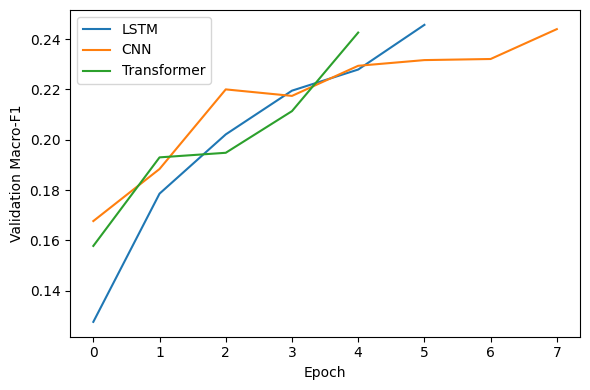

In [22]:
# ───────────────────────────── 11. F1 curves plot ────────────────────────
plt.figure(figsize=(6, 4))
plt.plot(hist_lstm, label='LSTM')
plt.plot(hist_cnn,  label='CNN')
plt.plot(hist_tfm,  label='Transformer')
plt.ylabel('Validation Macro-F1'); plt.xlabel('Epoch'); plt.legend(); plt.tight_layout()
plt.show()

In [24]:
# ───────────────────────────── 12. Comprehensive Model Evaluation ─────────────────────────────
def evaluate_model_comprehensive(model, x_test, y_test, label_cols, thresholds=None, name="Model"):
    """
    Comprehensive evaluation function that provides detailed performance analysis.
    
    Args:
        model: Trained Keras model
        x_test: Test features
        y_test: Test labels
        label_cols: List of emotion class names
        thresholds: Optional per-class thresholds (default 0.5 if None)
        name: Model name for display purposes
    
    Returns:
        metrics_df: DataFrame with precision, recall and F1 for each class
    """
    # Get predictions
    y_pred_prob = model.predict(x_test, batch_size=256, verbose=0)
    
    # Apply thresholds (either per-class or global 0.5)
    if thresholds is not None:
        y_pred = np.zeros_like(y_pred_prob, dtype=int)
        for i in range(y_pred_prob.shape[1]):
            y_pred[:, i] = (y_pred_prob[:, i] >= thresholds[i]).astype(int)
    else:
        y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Get per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    
    # Calculate macro and micro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='micro', zero_division=0
    )
    
    # Create a DataFrame for better visualization
    metrics_df = pd.DataFrame({
        'Emotion': label_cols,
        'Precision': precision,
        'Recall': recall, 
        'F1-Score': f1,
        'Support': support,
        'Threshold': thresholds if thresholds is not None else [0.5] * len(label_cols)
    })
    
    # Sort by F1 score (descending)
    metrics_df = metrics_df.sort_values('F1-Score', ascending=False)
    
    # Print overview report
    print(f"\n{'='*20} {name} Evaluation {'='*20}")
    print(f"Macro-Precision: {macro_precision:.4f} | Macro-Recall: {macro_recall:.4f} | Macro-F1: {macro_f1:.4f}")
    print(f"Micro-Precision: {micro_precision:.4f} | Micro-Recall: {micro_recall:.4f} | Micro-F1: {micro_f1:.4f}")
    
    # Display top 5 and bottom 5 emotions by F1 score
    pd.set_option('display.max_rows', None)
    pd.set_option('display.precision', 4)
    print("\nTop 5 classes:")
    print(metrics_df.head(5).to_string(index=False))
    print("\nBottom 5 classes:")
    print(metrics_df.tail(5).to_string(index=False))
    
    # Calculate class distribution to show imbalance
    class_dist = y_test.sum(axis=0) / len(y_test)
    metrics_df['Class_Distribution'] = [class_dist[i] for i in range(len(label_cols))]
    
    # Save results
    metrics_df.to_csv(f'{name.lower()}_evaluation_metrics.csv', index=False)
    print(f"Metrics saved to {name.lower()}_evaluation_metrics.csv")
    
    return metrics_df

def plot_metrics_by_emotion(metrics_df, title="Model Performance by Emotion", n_emotions=10):
    """
    Plot the precision, recall, and F1 scores for top emotions.
    
    Args:
        metrics_df: DataFrame with metrics (from evaluate_model_comprehensive)
        title: Plot title
        n_emotions: Number of top emotions to display
    """
    # Get top emotions by F1 score for visualization
    plot_df = metrics_df.head(n_emotions).copy()
    
    # Melt the DataFrame for easier plotting
    plot_df_melted = pd.melt(
        plot_df, 
        id_vars=['Emotion', 'Support', 'Threshold'],
        value_vars=['Precision', 'Recall', 'F1-Score'],
        var_name='Metric', 
        value_name='Score'
    )
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Bar plot for metrics
    g = sns.barplot(x='Emotion', y='Score', hue='Metric', data=plot_df_melted)
    
    # Add threshold as text on top of the bars
    for i, emotion in enumerate(plot_df['Emotion']):
        threshold = plot_df.loc[plot_df['Emotion'] == emotion, 'Threshold'].values[0]
        support = plot_df.loc[plot_df['Emotion'] == emotion, 'Support'].values[0]
        plt.text(i, 1.05, f'thr={threshold:.2f}\nn={support}', ha='center')
    
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.15)  # Leave space for the annotations
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Metric')
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_for_class(model, x_test, y_test, class_idx, class_name, threshold=0.5):
    """
    Creates and plots a confusion matrix for a specific class.
    
    Args:
        model: Trained model
        x_test: Test features
        y_test: Test labels
        class_idx: Index of the class to analyze
        class_name: Name of the class
        threshold: Classification threshold
    """
    # Get predictions for this specific class
    y_pred_prob = model.predict(x_test, batch_size=256, verbose=0)[:, class_idx]
    y_pred_class = (y_pred_prob >= threshold).astype(int)
    y_true_class = y_test[:, class_idx]
    
    # Create confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for "{class_name}"')
    
    # Calculate metrics for this class
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nDetailed metrics for class '{class_name}':")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"True Positives: {tp}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Negatives: {tn}")
    
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{class_name.lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

def plot_roc_curves(model, x_test, y_test, label_cols, top_n=5):
    """
    Plot ROC curves for the top n classes with highest AUC.
    
    Args:
        model: Trained model
        x_test: Test features
        y_test: Test labels
        label_cols: List of emotion class names
        top_n: Number of top classes to plot
    """
    y_pred_prob = model.predict(x_test, batch_size=256, verbose=0)
    
    # Calculate AUC for each class
    auc_scores = []
    for i in range(len(label_cols)):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores.append((label_cols[i], auc_score, fpr, tpr))
    
    # Sort by AUC
    auc_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Plot top n
    plt.figure(figsize=(10, 8))
    for i in range(min(top_n, len(auc_scores))):
        emotion, auc_score, fpr, tpr = auc_scores[i]
        plt.plot(fpr, tpr, lw=2, label=f'{emotion} (AUC = {auc_score:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Top {top_n} Emotions')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"roc_curves_top{top_n}.png", dpi=300)
    plt.show()
    
    return auc_scores

def plot_model_comparison(models_metrics, title="Model Comparison"):
    """
    Compare F1 scores across different models.
    
    Args:
        models_metrics: List of tuples (model_name, metrics_df)
        title: Plot title
    """
    plt.figure(figsize=(12, 6))
    
    # Get common emotions in all models (top 10)
    common_emotions = set(models_metrics[0][1]['Emotion'].head(10))
    for _, df in models_metrics[1:]:
        common_emotions &= set(df['Emotion'].head(10))
    common_emotions = list(common_emotions)[:10]  # Limit to top 10
    
    # Prepare data for plotting
    model_names = [name for name, _ in models_metrics]
    emotion_f1_scores = {}
    
    for emotion in common_emotions:
        emotion_f1_scores[emotion] = []
        for _, df in models_metrics:
            f1 = df.loc[df['Emotion'] == emotion, 'F1-Score'].values[0]
            emotion_f1_scores[emotion].append(f1)
    
    # Plot
    x = np.arange(len(model_names))
    width = 0.8 / len(common_emotions)
    
    for i, emotion in enumerate(common_emotions):
        plt.bar(x + i*width - 0.4 + width/2, emotion_f1_scores[emotion], 
                width=width, label=emotion)
    
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title(title, fontsize=14)
    plt.xticks(x, model_names)
    plt.ylim(0, 1.0)
    plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

def analyze_error_patterns(model, x_test, y_test, label_cols, thresholds=None):
    """
    Analyze error patterns in the model predictions.
    
    Args:
        model: Trained model
        x_test: Test features
        y_test: Test labels
        label_cols: List of emotion class names
        thresholds: Optional per-class thresholds
    """
    # Get predictions
    y_pred_prob = model.predict(x_test, batch_size=256, verbose=0)
    
    # Apply thresholds
    if thresholds is not None:
        y_pred = np.zeros_like(y_pred_prob, dtype=int)
        for i in range(y_pred_prob.shape[1]):
            y_pred[:, i] = (y_pred_prob[:, i] >= thresholds[i]).astype(int)
    else:
        y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Identify common error patterns
    # 1. False positives and false negatives per class
    fp_counts = ((y_pred == 1) & (y_test == 0)).sum(axis=0)
    fn_counts = ((y_pred == 0) & (y_test == 1)).sum(axis=0)
    
    # 2. Co-occurrence matrix of errors
    error_indices = np.where(y_pred != y_test)
    error_pairs = []
    
    for i in range(len(error_indices[0])):
        sample_idx = error_indices[0][i]
        class_idx = error_indices[1][i]
        
        # For each error, find other errors in the same sample
        for other_class_idx in range(y_test.shape[1]):
            if other_class_idx != class_idx and y_pred[sample_idx, other_class_idx] != y_test[sample_idx, other_class_idx]:
                error_pairs.append((class_idx, other_class_idx))
    
    # Count error co-occurrences
    from collections import Counter
    error_cooccur = Counter(error_pairs)
    
    # Prepare results
    error_df = pd.DataFrame({
        'Emotion': label_cols,
        'False Positives': fp_counts,
        'False Negatives': fn_counts,
        'FP Rate': fp_counts / np.maximum((y_test == 0).sum(axis=0), 1),
        'FN Rate': fn_counts / np.maximum((y_test == 1).sum(axis=0), 1)
    })
    
    # Sort by total errors
    error_df['Total Errors'] = error_df['False Positives'] + error_df['False Negatives']
    error_df = error_df.sort_values('Total Errors', ascending=False)
    
    print("\nTop 5 classes with most errors:")
    print(error_df.head(5).to_string(index=False))
    
    # Plot error distribution
    plt.figure(figsize=(12, 6))
    error_df_plot = error_df.head(10).copy()  # Top 10 classes with errors
    
    x = np.arange(len(error_df_plot))
    width = 0.35
    
    plt.bar(x - width/2, error_df_plot['False Positives'], width, label='False Positives')
    plt.bar(x + width/2, error_df_plot['False Negatives'], width, label='False Negatives')
    
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Error Distribution by Emotion Class')
    plt.xticks(x, error_df_plot['Emotion'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig("error_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return error_df


Running CNN hyperparameter tuning...

Running cross-validation on models...

Training final models...

Running comprehensive evaluation...

==================== BiLSTM Evaluation ====================
Macro-Precision: 0.4279 | Macro-Recall: 0.1560 | Macro-F1: 0.1975
Micro-Precision: 0.6120 | Micro-Recall: 0.1467 | Micro-F1: 0.2367

Top 5 classes:
   Emotion  Precision  Recall  F1-Score  Support  Threshold
 gratitude     0.8824  0.7536    0.8129     1185        0.5
      love     0.5923  0.6847    0.6352      834        0.5
 amusement     0.5842  0.6171    0.6002      922        0.5
      fear     0.5572  0.3601    0.4375      311        0.5
admiration     0.7065  0.2046    0.3173     1706        0.5

Bottom 5 classes:
       Emotion  Precision  Recall  F1-Score  Support  Threshold
         pride        0.0     0.0       0.0      120        0.5
   nervousness        0.0     0.0       0.0      175        0.5
     annoyance        0.0     0.0       0.0     1374        0.5
disappointment  

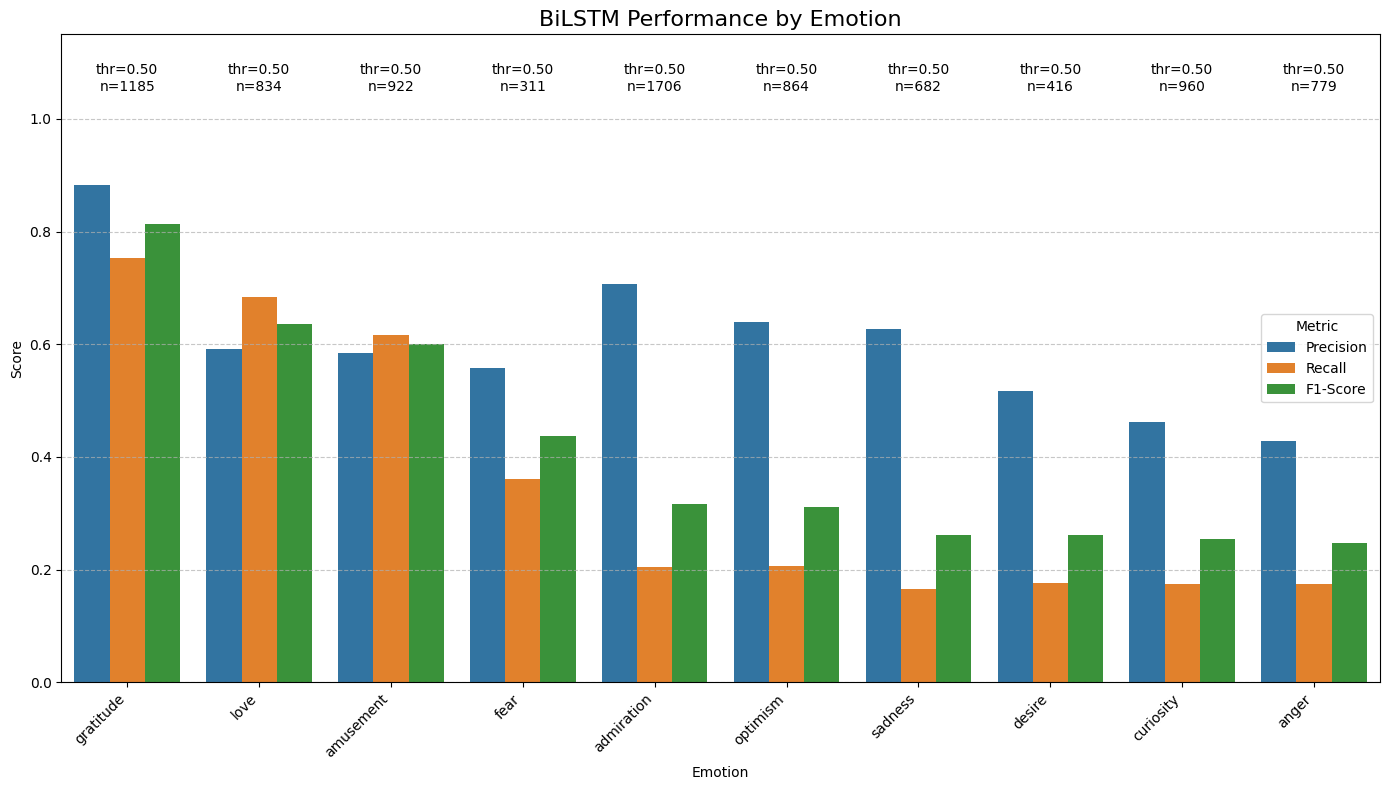

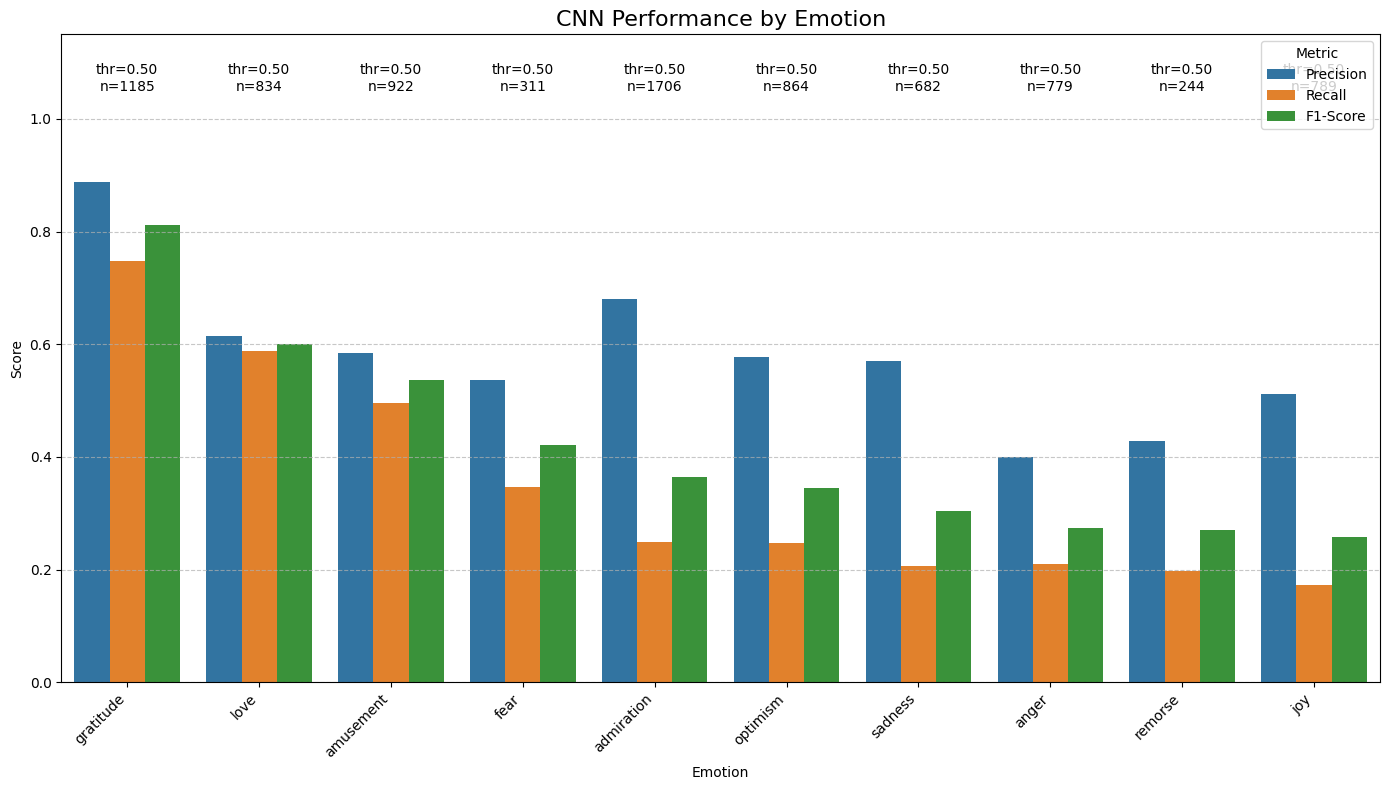

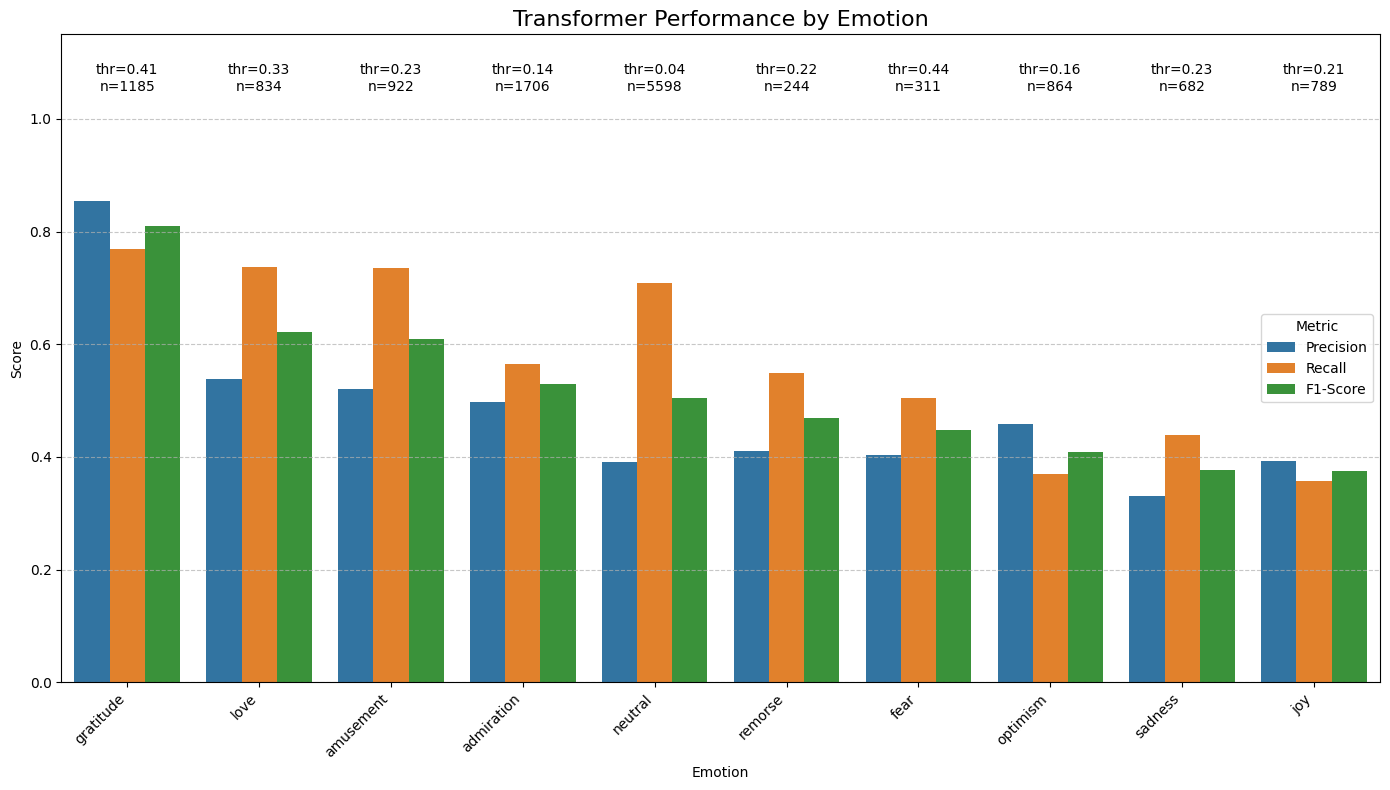

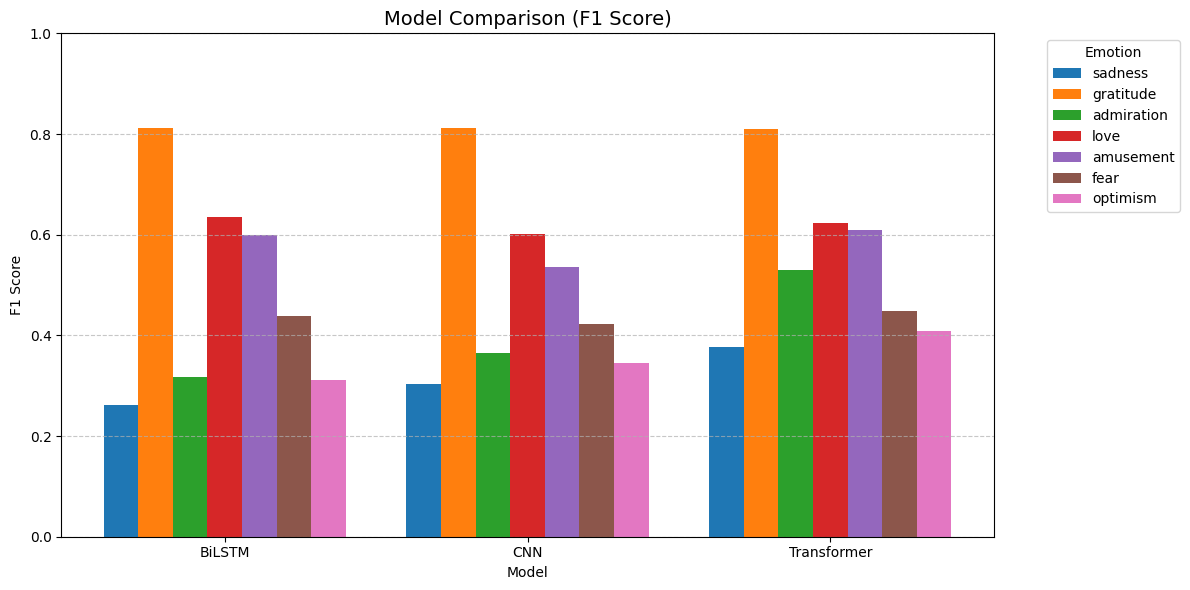


Detailed metrics for class 'gratitude':
Precision: 0.8538
Recall: 0.7688
F1-Score: 0.8091
True Positives: 911, False Positives: 156
False Negatives: 274, True Negatives: 19782


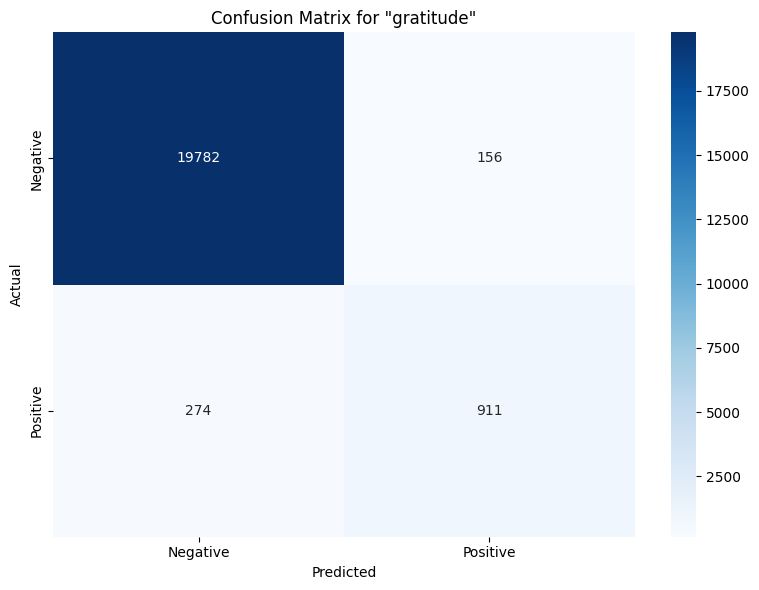

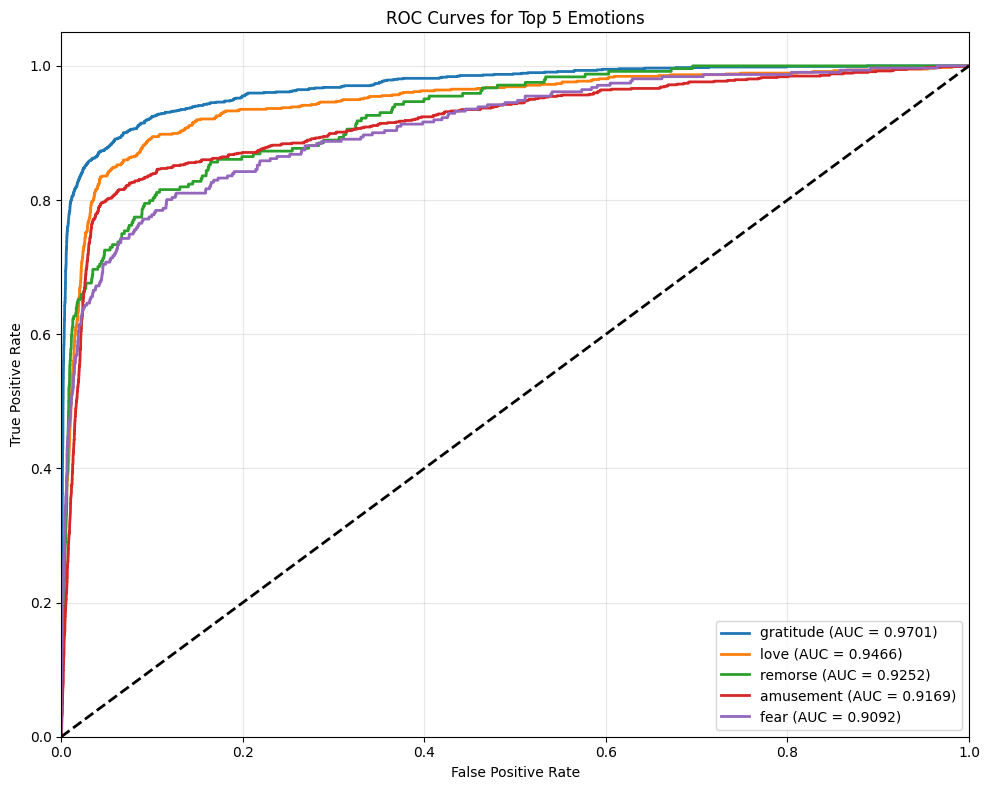


Top 5 classes with most errors:
    Emotion  False Positives  False Negatives  FP Rate  FN Rate  Total Errors
    neutral             6171             1628   0.3975   0.2908          7799
   approval             3221             1116   0.1661   0.6429          4337
  annoyance             1487              959   0.0753   0.6980          2446
disapproval             1524              743   0.0763   0.6483          2267
realization             1573              644   0.0777   0.7335          2217


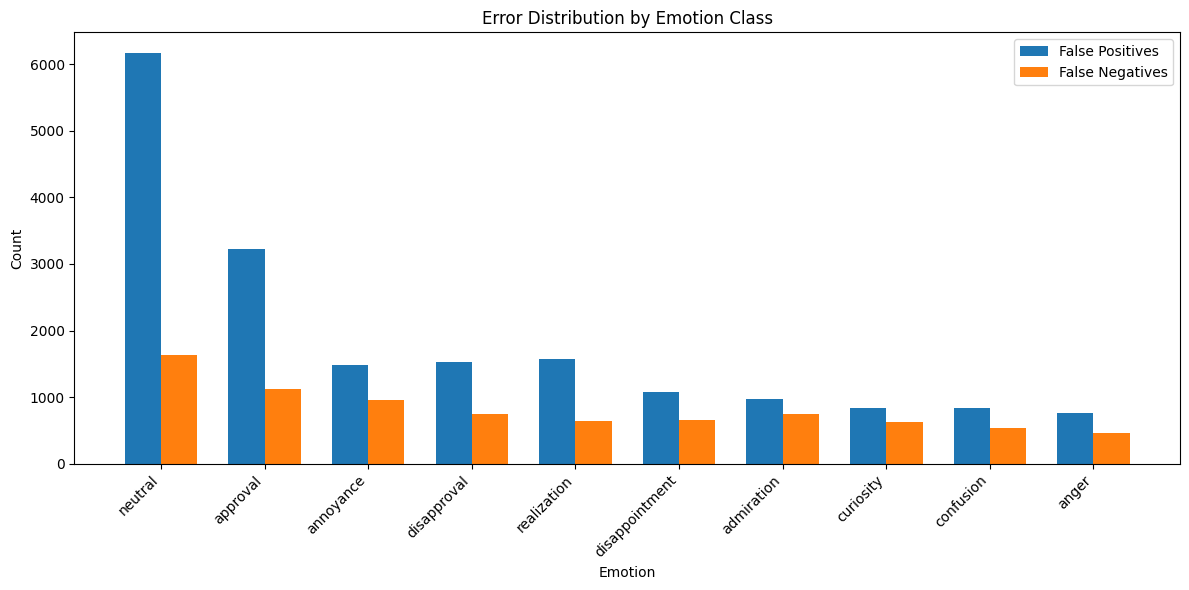


Evaluation complete!


In [25]:
# ───────────────────────────── 13. Run Evaluation ─────────────────────────
if __name__ == "__main__":
    # Uncomment the following lines to run the hyperparameter tuning and cross-validation
    
    # Run hyperparameter tuning for CNN model
    print("\nRunning CNN hyperparameter tuning...")
    # best_cnn_params = hyperparameter_search_cnn_efficient()  # Use efficient version for faster execution
    
    # Now define a build function with the optimal parameters
    # def build_optimal_cnn():
    #     return build_cnn(
    #         emb_dim=best_cnn_params['emb_dim'],
    #         filters=best_cnn_params['filters'],
    #         kernel_sizes=(3, 4, 5)
    #     )
    
    # Run cross-validation on models
    print("\nRunning cross-validation on models...")
    # cv_lstm_results = cross_validate_model_efficient(build_lstm, "BiLSTM")
    # cv_cnn_results = cross_validate_model_efficient(build_optimal_cnn if 'best_cnn_params' in locals() else build_cnn, "CNN")
    
    # Train the final models if not already trained
    print("\nTraining final models...")
    if 'lstm_model' not in globals():
        lstm_model, hist_lstm = train_model(build_lstm, 'LSTM')
    if 'cnn_model' not in globals():
        cnn_model, hist_cnn = train_model(build_cnn, 'CNN')
    if 'tfm_model' not in globals():
        tfm_model, hist_tfm = train_model(build_transformer, 'TFM')
    
    # Comprehensive evaluation
    print("\nRunning comprehensive evaluation...")
    lstm_metrics = evaluate_model_comprehensive(lstm_model, test_x, test_y, label_cols, name="BiLSTM")
    cnn_metrics = evaluate_model_comprehensive(cnn_model, test_x, test_y, label_cols, name="CNN")
    tfm_metrics = evaluate_model_comprehensive(tfm_model, test_x, test_y, label_cols, thresholds=opt_thr, name="Transformer")
    
    # Generate visualizations
    plot_metrics_by_emotion(lstm_metrics, title="BiLSTM Performance by Emotion")
    plot_metrics_by_emotion(cnn_metrics, title="CNN Performance by Emotion")
    plot_metrics_by_emotion(tfm_metrics, title="Transformer Performance by Emotion")
    
    # Compare models
    model_comparison = [("BiLSTM", lstm_metrics), ("CNN", cnn_metrics), ("Transformer", tfm_metrics)]
    plot_model_comparison(model_comparison, title="Model Comparison (F1 Score)")
    
    # Analyze top performing emotion in detail
    top_emotion = tfm_metrics['Emotion'].iloc[0]
    top_idx = label_cols.index(top_emotion)
    top_threshold = opt_thr[top_idx] if opt_thr is not None else 0.5
    
    plot_confusion_matrix_for_class(
        tfm_model, test_x, test_y, 
        top_idx, top_emotion, threshold=top_threshold
    )
    
    # ROC curve analysis
    plot_roc_curves(tfm_model, test_x, test_y, label_cols, top_n=5)
    
    # Error analysis
    error_analysis = analyze_error_patterns(tfm_model, test_x, test_y, label_cols, thresholds=opt_thr)
    
    print("\nEvaluation complete!")

In [27]:
# ───────────────────────────── 14. Save Models for Part 2 ────────────────────
def save_model_for_inference(model, word_index, max_len, label_cols, output_dir):
    """
    Save a model and all necessary preprocessing components for later inference.
    
    Args:
        model: Trained Keras model
        word_index: Dictionary mapping words to indices
        max_len: Maximum sequence length
        label_cols: List of emotion labels
        output_dir: Directory to save model and components
    """
    import os
    import json
    import pickle
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Save the model
    model.save(os.path.join(output_dir, "model.h5"))
    
    # 2. Save vocabulary (word_index)
    with open(os.path.join(output_dir, "word_index.pkl"), "wb") as f:
        pickle.dump(word_index, f)
    
    # 3. Save label columns
    with open(os.path.join(output_dir, "label_cols.json"), "w") as f:
        json.dump(label_cols, f)
    
    # 4. Save configuration parameters
    config = {
        "max_len": max_len,
        "model_type": model.name if hasattr(model, "name") else "unknown"
    }
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(config, f)
    
    # 5. Save optimized thresholds if available
    if 'opt_thr' in globals():
        np.save(os.path.join(output_dir, "opt_thresholds.npy"), opt_thr)
    
    print(f"Model and components saved to {output_dir}")

# Save models for Part 2
# Uncomment these lines when ready to save models for Part 2
save_model_for_inference(lstm_model, word2idx, MAX_LEN, label_cols, "../models/lstm_sentiment")
save_model_for_inference(cnn_model, word2idx, MAX_LEN, label_cols, "../models/cnn_sentiment")
save_model_for_inference(tfm_model, word2idx, MAX_LEN, label_cols, "../models/transformer_sentiment")

class SentimentInferenceModel:
    """
    Class for loading and using saved sentiment models for inference.
    """
    def __init__(self, model_dir):
        """
        Load a model and its components from a directory.
        
        Args:
            model_dir: Directory containing saved model and components
        """
        import os
        import json
        import pickle
        import numpy as np
        from tensorflow import keras
        import re
        
        # Load model
        self.model = keras.models.load_model(os.path.join(model_dir, "model.h5"))
        
        # Load vocabulary
        with open(os.path.join(model_dir, "word_index.pkl"), "rb") as f:
            self.word_index = pickle.load(f)
        
        # Load label columns
        with open(os.path.join(model_dir, "label_cols.json"), "r") as f:
            self.label_cols = json.load(f)
        
        # Load configuration
        with open(os.path.join(model_dir, "config.json"), "r") as f:
            config = json.load(f)
            self.max_len = config["max_len"]
            self.model_type = config.get("model_type", "unknown")
        
        # Load thresholds if available
        thresh_path = os.path.join(model_dir, "opt_thresholds.npy")
        if os.path.exists(thresh_path):
            self.thresholds = np.load(thresh_path)
        else:
            self.thresholds = None
        
        print(f"Loaded {self.model_type} model with {len(self.label_cols)} emotion classes")
    
    def preprocess_text(self, text):
        """
        Apply the same preprocessing as during training.
        
        Args:
            text: Raw text string
            
        Returns:
            Preprocessed and padded sequence
        """
        # Apply same cleaning as in training
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)            # Remove HTML tags
        text = re.sub(r'[^a-z0-9\s]', '', text)      # Remove punctuation/special chars
        text = re.sub(r'\s+', ' ', text).strip()     # Collapse whitespace
        
        # Convert to sequence
        seq = [self.word_index.get(w, 1) for w in text.split()]  # 1 is OOV
        
        # Pad sequence
        padded_seq = (seq[:self.max_len] + [0] * self.max_len)[:self.max_len]
        
        # Convert to numpy array and reshape for model
        return np.array([padded_seq], dtype=np.int16)
    
    def predict(self, text, threshold=None, top_k=3):
        """
        Predict emotions for a text input.
        
        Args:
            text: Raw text string
            threshold: Classification threshold (use class-specific if None)
            top_k: Number of top emotions to return
            
        Returns:
            Dictionary with predicted emotions and scores
        """
        # Preprocess the text
        seq = self.preprocess_text(text)
        
        # Get model predictions
        pred_scores = self.model.predict(seq, verbose=0)[0]
        
        # Apply thresholds (either per-class or global)
        if threshold is None and self.thresholds is not None:
            # Use per-class optimized thresholds
            emotions_above_threshold = []
            for i, score in enumerate(pred_scores):
                if score >= self.thresholds[i]:
                    emotions_above_threshold.append((self.label_cols[i], float(score)))
        else:
            # Use fixed threshold (default 0.5 if not provided)
            threshold = threshold if threshold is not None else 0.5
            emotions_above_threshold = [(self.label_cols[i], float(score)) 
                                       for i, score in enumerate(pred_scores) 
                                       if score >= threshold]
        
        # Get top K emotions
        top_emotions = sorted([(self.label_cols[i], float(score)) 
                              for i, score in enumerate(pred_scores)], 
                             key=lambda x: x[1], reverse=True)[:top_k]
        
        return {
            "raw_scores": {self.label_cols[i]: float(score) for i, score in enumerate(pred_scores)},
            "emotions_above_threshold": emotions_above_threshold,
            "top_emotions": top_emotions
        }

Model and components saved to ../models/lstm_sentiment


Model and components saved to ../models/cnn_sentiment
Model and components saved to ../models/transformer_sentiment


In [28]:
#test